In [1]:
import networkx as nx
import numpy as np
from src.metaqaoa import gene_qaoa_ansatz, gene_random_instance, gene_qaoa_layers, gene_ham, MetaQAOA, fig7_instance1, fig7_instance2
import mindspore as ms
from mindspore import Tensor, nn, ops
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

5
7


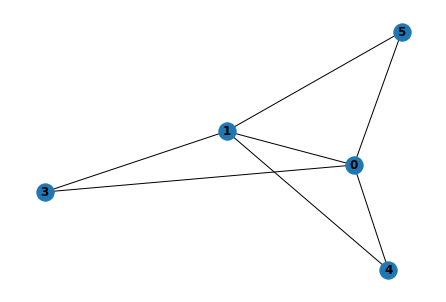

In [2]:
P = 10
g = fig7_instance1()
# g = fig7_instance2()
print(len(g.nodes))
print(len(g.edges))
nx.draw(g, with_labels=True, font_weight='bold')

In [3]:
cuts = []
for i in g.nodes:
    # print('one size:', [i], 'cut=', nx.cut_size(g, [i]))           # 一组1个节点、另一组4个节点的所有情况
    cuts.append(nx.cut_size(g, [i]))
    for j in range(i):
        # print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组2个节点、另一组3个节点的所有情况
        cuts.append(nx.cut_size(g, [i, j]))

        for k in range(j):
            # print('one size:', [i, j, k], 'cut=', nx.cut_size(g, [i, j, k]))  # 一组3个节点、另一组3个节点的所有情况
            cuts.append(nx.cut_size(g, [i, j, k]))

            for l in range(j):
                cuts.append(nx.cut_size(g, [i, j, k, l]))
print(max(cuts))


6


In [4]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

In [5]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc


In [6]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb


In [7]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham


In [8]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ


In [9]:
# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.svg()


In [10]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练


In [11]:
for i in range(200):
    loss = train_net()
    cut = (len(g.edges) - loss) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", loss:", loss, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数


train step: 0 , loss: [-0.00440474] , cut: [3.5022023]
train step: 10 , loss: [-2.84611] , cut: [4.923055]
train step: 20 , loss: [-4.4490066] , cut: [5.7245035]
train step: 30 , loss: [-4.6709485] , cut: [5.835474]
train step: 40 , loss: [-4.876907] , cut: [5.9384537]
train step: 50 , loss: [-4.9059863] , cut: [5.9529934]
train step: 60 , loss: [-4.916393] , cut: [5.9581966]
train step: 70 , loss: [-4.931366] , cut: [5.965683]
train step: 80 , loss: [-4.934742] , cut: [5.967371]
train step: 90 , loss: [-4.934774] , cut: [5.967387]
train step: 100 , loss: [-4.934855] , cut: [5.9674273]
train step: 110 , loss: [-4.935036] , cut: [5.967518]
train step: 120 , loss: [-4.935097] , cut: [5.9675484]
train step: 130 , loss: [-4.935116] , cut: [5.967558]
train step: 140 , loss: [-4.9351196] , cut: [5.96756]
train step: 150 , loss: [-4.93512] , cut: [5.96756]
train step: 160 , loss: [-4.9351206] , cut: [5.9675603]
train step: 170 , loss: [-4.935121] , cut: [5.967561]
train step: 180 , loss: [-4.